# K-Nearest Neighbours Algorithm

A clustering algorithm.

Data wrangling:
- Summation of Plant Production, Imports and Renewables Production in early implementations was carried out to get a concrete picture of all the required generation to the grid. This was not used in the final implemetnation but was left in for completeness sake.
- Categorisation of Maximum Demand for classifier: A histogram was used to visualise the distribution of the data following which three categories were defined. These were selected as evenly distributed as possible, with the aim of creating an unbiased data set.

Inputs:
- Population
- Maximum Temperature

Outputs:
- Maximum Demand

Evaluation metrics:
- Accuracy
- Precision
- Recall
- F1-score
- Classification Report showing performance metrics for each category
- Confusion Matrix

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score ,confusion_matrix, precision_score, recall_score, f1_score, classification_report, make_scorer
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Load the datasets
train_data = pd.read_csv('data/train_data.csv')
test_data = pd.read_csv('data/test_data.csv')

In [3]:
# Add together Plant Production, Imports and Renewables production to get total output to the grid
# This was implemented during early testing, and was not used in the final algorithm
train_data_prod = train_data['Plant_Production_GWh'] + train_data ['Imports_GWh'] + train_data['Renewables_Production_GWh']
train_data['Grid_Output'] = pd.DataFrame(train_data_prod)
test_data_prod = test_data['Plant_Production_GWh'] + test_data ['Imports_GWh'] + test_data['Renewables_Production_GWh']
test_data['Grid_Output'] = pd.DataFrame(test_data_prod)

# train_data.head(3)

In [4]:
train_data.head(3)

,Date,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,emissions_c02_GG,GDP_bln,Population_k,tavg,tmax,tmin,Grid_Output
0,2003-01-01,0.36,182.08,0.0,0.0,47.52,4.82,398.58,13.2,15.6,10.9,182.08
1,2003-02-01,0.40,187.10,0.0,0.0,52.80,4.82,398.58,10.4,13.0,7.9,187.10
2,2003-03-01,0.34,176.37,0.0,0.0,44.88,4.82,398.58,12.7,15.7,9.8,176.37


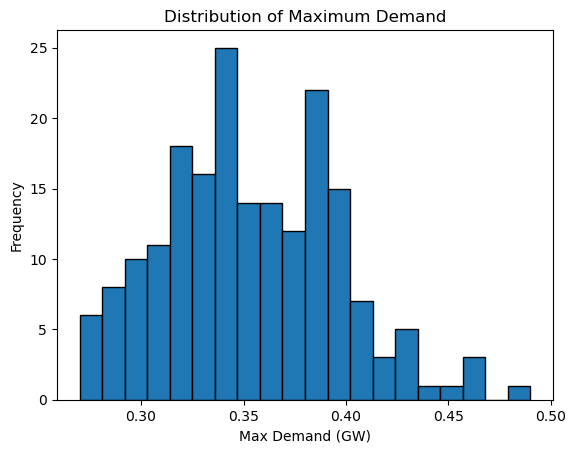

In [5]:
# Show the target variable (Max_Demand_gW) on a histogram
counts, bin_edges, _ = plt.hist(train_data['Max_Demand_GW'], bins=20, edgecolor='black')

plt.xlabel('Max Demand (GW)')
plt.ylabel('Frequency')
plt.title('Distribution of Maximum Demand')

plt.show()

In [6]:
bin_edges

array([0.27 , 0.281, 0.292, 0.303, 0.314, 0.325, 0.336, 0.347, 0.358,
       0.369, 0.38 , 0.391, 0.402, 0.413, 0.424, 0.435, 0.446, 0.457,
       0.468, 0.479, 0.49 ])

In [7]:
# Manually define the bin edges since the lower frequency ones can be grouped.
# This will directly correlate to the number of clusters in the data set.
# The number of bin edges was selected through a trial and improvement exercise.
# The below indicates that there will be three clusters in the data set.

#bin_edges = [-np.inf, 120, 160, np.inf]
bin_edges = [-np.inf, 0.330, 0.365, np.inf]

In [8]:
# Create labels for the bins
labels = [i for i in range(len(bin_edges) - 1)]

# Use pd.cut to categorize the data into bins
train_data['Max_Demand_Cat'] = pd.cut(train_data['Max_Demand_GW'], bins=bin_edges, labels=labels, include_lowest=True)
test_data['Max_Demand_Cat'] = pd.cut(test_data['Max_Demand_GW'], bins=bin_edges, labels=labels, include_lowest=True)

In [9]:
# Display the ranges for each cluster
bin_ranges = pd.DataFrame({'Bin': labels,'Bin Edge Lower': bin_edges[:-1],'Bin Edge Upper': bin_edges[1:],})
bin_ranges

,Bin,Bin Edge Lower,Bin Edge Upper
0,0,-inf,0.330
1,1,0.330,0.365
2,2,0.365,inf


In [10]:
# Check how many instances of each category are present in the training set to try and train fairly
class_counts = train_data['Max_Demand_Cat'].value_counts()
class_counts

Max_Demand_Cat
2    70
0    69
1    53
Name: count, dtype: int64

In [11]:
# Check how many instances of each category are present in the test set to try and train fairly
class_counts = test_data['Max_Demand_Cat'].value_counts()
class_counts

Max_Demand_Cat
2    41
1     4
0     3
Name: count, dtype: int64

In [12]:
test_data.head(3)
#test_data

,Date,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,emissions_c02_GG,GDP_bln,Population_k,tavg,tmax,tmin,Grid_Output,Max_Demand_Cat
0,2019-01-01,0.44,224.76,46.96,10.45,75.11,14.19,504.06,11.6,14.4,8.8,282.17,2
1,2019-02-01,0.43,199.54,60.59,11.93,73.41,14.19,504.06,12.0,15.3,8.7,272.06,2
2,2019-03-01,0.39,199.28,58.86,16.83,66.58,14.19,504.06,14.5,17.7,11.2,274.97,2


In [13]:
# Prepare the data
X_train = train_data[['tmax', 'Population_k']]
y_train = train_data['Max_Demand_Cat']
X_test = test_data[['tmax', 'Population_k']]
y_test = test_data['Max_Demand_Cat'] 

# Normalize features
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
# Normalize the test set on the same scale the train set was normalized upon
X_test_normalized = scaler.transform(X_test)

The parameters of the KNN Algorithm were first tweaked as follows as a form of experimentation, with information being taken from the scikit learn documentation accessed 03/12/2023:
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

## Weights Parameter

The 'weights' parameter can either be set to *uniform* or *distance* whereby the former weights all points in each neighbourhood equally, while the latter weights points by the inverse of their distance such that close neighbours of a query point will have a greater influence than neighbours which are further away.

## Algorithm Parameter

Can either be 'auto', 'ball_tree', 'kd_tree' or 'brute'

Tuning this paramater to any one of 'auto', 'ball_tree', 'kd_tree' or 'brute' had no effect on the model. However, in the context of the model being applied to a more vast and large data set, ball_tree was selected since it appears most suitable. The features are not very high dimensional, thus the Ball Tree algorithm seems more suitable.

## Leaf Size

Known to affect the speed of construction and query and the memory required to store the tree. The documentation states that "the optimal value depends on the nature of the problem".

Tuning this parameter had once again no effect on the model. Therefore it was left to the 'auto' value of 30. I decided to continue testing since I was sure that the scale of features was correct, outliers had been tackled and I am aware that the data set is not very large, which might have an impact.

## p parameter

The p parameter is the power parameter fir the Minkwoski metrics.

- p=1: Manhattan Distance
- p=2: Euclidean distance

The default p=2 resulted in better metrics than p=1.

In [14]:
# The below cell presents the code used for preliminary testing

##The knn_model below was used to experiment with the possible tuning parameters

##Train the KNN model

k_neighbors = 3  # You can adjust this value based on your preference
knn_model = KNeighborsClassifier(n_neighbors=k_neighbors, weights='uniform', algorithm='ball_tree')
knn_model.fit(X_train_normalized, y_train)

##Make predictions on the testing set
y_pred = knn_model.predict(X_test_normalized)

# Grid Search Parameter Tuning

After reading about and becoming aware of the possible tuning parameters for this algorithm, GridSearch was used to find the best parameters. Due to memory issues, the 'n_neighbors', 'algorithm', 'weights', 'leaf_size' and 'n_neighbors' parameters were passed to this algorithm separately, combining three features at a time.
For example, the leaf size options were first set to [30, 40]. Since 30 was found to be best, leaf size was then set to [20 ,30]. Then 20 was found to be best, so it was set to [10,20]. The same was repeated in other cases.

In [15]:
from sklearn.model_selection import GridSearchCV
import itertools

## Define ranges for paramaters
k_neighbours = [3] 
weights = ['uniform', 'distance']
algorithm = ['ball_tree', 'kd_tree','brute']
leaf_size = [30]  #since leaf size had little effect on the training metrics, it was set to the default value of 30 since smaller leaf size means more computational time
p = [1, 2]

# Create the parameter grid using itertools.product
param_grid = {
    #'n_neighbors': k_neighbours,
    'weights': weights,
    'algorithm': algorithm,
    #'leaf_size': leaf_size,
    'p': p
}

param_combinations = list(itertools.product(*param_grid.values()))

# Create the SVR model
knn = KNeighborsClassifier()

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=knn, param_grid={}, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)

# Set the param_grid attribute to the generated parameter grid
grid_search.param_grid = {param: values for param, values in zip(param_grid.keys(), zip(*param_combinations))}

# Fit the GridSearchCV instance on your data
grid_search.fit(X_train_normalized, y_train)

# Retrieve the best hyperparameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(best_params)
print(best_score)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
{'algorithm': 'ball_tree', 'p': 2, 'weights': 'uniform'}
0.6758434547908233


Following the above experiments, the following parameters were found to be optimal for the KNN Model:
- Number of Neighbours: 3 - fixed by categories highlighted above. As expected, the lower number of clusters chosen, the better the performance, as even an untrained model has a better chance of guessing the correct cluster.
- Weights: uniform
- Algorithm: ball tree
- Leaf size: 30 - this parameter proved to have a small influence on the outcome. Thus 30 was selected since it is the default value, and it is known that a smaller leaf size increases computational time.
- p parameter: 2 => Euclidean distance

In [16]:
#Train the KNN model

knn_model = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='ball_tree', p=2, leaf_size=30)
knn_model.fit(X_train_normalized, y_train)

##Make predictions on the testing set
y_pred = knn_model.predict(X_test_normalized)

In [17]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

# Precision, Recall, and F1 Score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Classification Report
class_report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{class_report}')

Accuracy: 0.7708333333333334
Confusion Matrix:
[[ 0  1  2]
 [ 1  3  0]
 [ 1  6 34]]
Precision: 0.831712962962963
Recall: 0.7708333333333334
F1 Score: 0.79004329004329
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.30      0.75      0.43         4
           2       0.94      0.83      0.88        41

    accuracy                           0.77        48
   macro avg       0.41      0.53      0.44        48
weighted avg       0.83      0.77      0.79        48



In [18]:
# Add the predicted category to the test_data DataFrame
test_data['Predicted_Category'] = y_pred

In [19]:
test_data.head(3)

,Date,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,emissions_c02_GG,GDP_bln,Population_k,tavg,tmax,tmin,Grid_Output,Max_Demand_Cat,Predicted_Category
0,2019-01-01,0.44,224.76,46.96,10.45,75.11,14.19,504.06,11.6,14.4,8.8,282.17,2,2
1,2019-02-01,0.43,199.54,60.59,11.93,73.41,14.19,504.06,12.0,15.3,8.7,272.06,2,2
2,2019-03-01,0.39,199.28,58.86,16.83,66.58,14.19,504.06,14.5,17.7,11.2,274.97,2,2


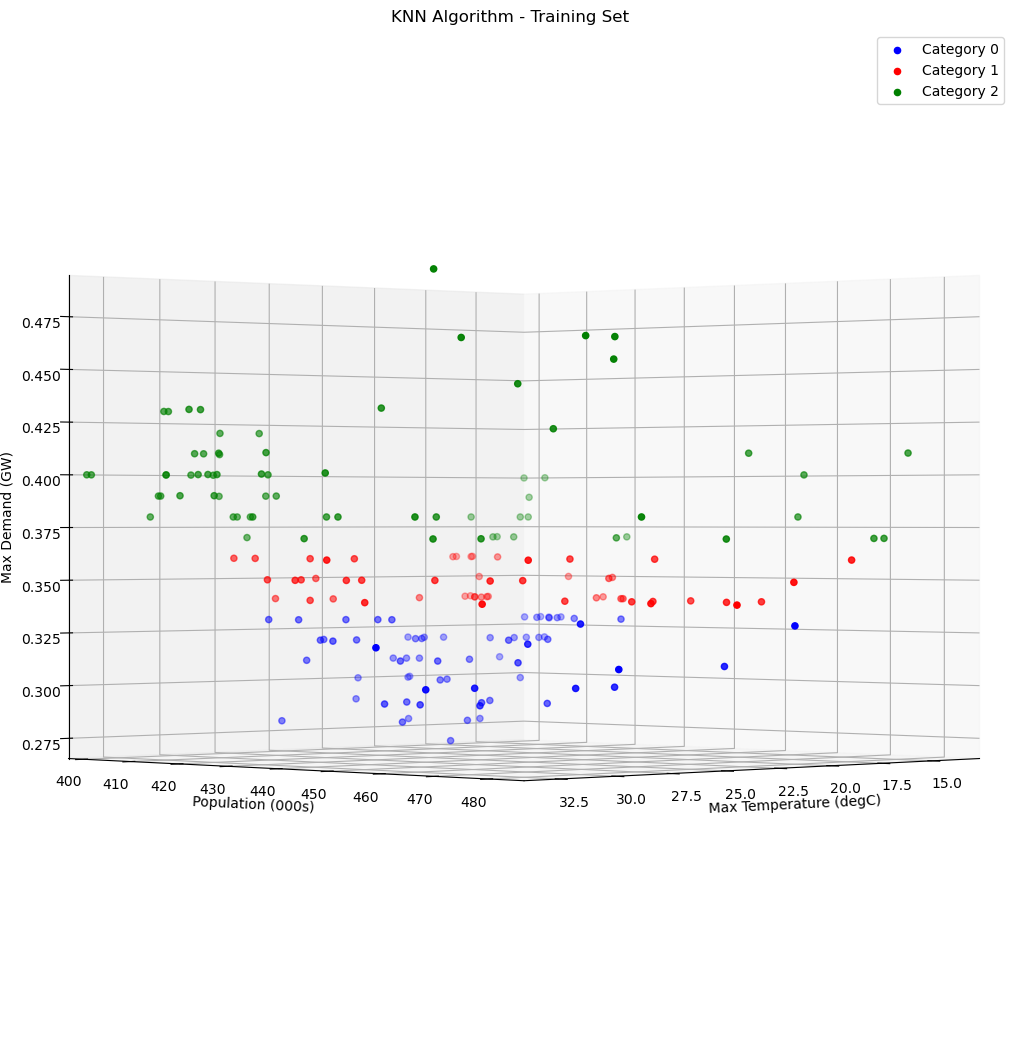

In [20]:
from mpl_toolkits.mplot3d import Axes3D

categories = [0, 1, 2]

# Create a colormap with a color for each category
colors = ['blue', 'red', 'green']

# Visualize the training set
fig = plt.figure(figsize=(15, 13))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each category
for category, color in zip(categories, colors):
    subset = train_data[train_data['Max_Demand_Cat'] == category]
    ax.scatter(subset['tmax'], subset['Population_k'], subset['Max_Demand_GW'], label=f'Category {category}', c=color)

ax.set_title('KNN Algorithm - Training Set')
ax.set_xlabel('Max Temperature (degC)')
ax.set_ylabel('Population (000s)')
ax.set_zlabel('Max Demand (GW)')

ax.view_init(elev=0, azim=45)

# Set axis limits and turn off autoscale
ax.set_xlim([train_data['tmax'].min(), train_data['tmax'].max()])
ax.set_ylim([train_data['Population_k'].min(), train_data['Population_k'].max()])
ax.set_zlim([train_data['Max_Demand_GW'].min(), train_data['Max_Demand_GW'].max()])
ax.autoscale(False)

# Add legend
ax.legend()

plt.show()

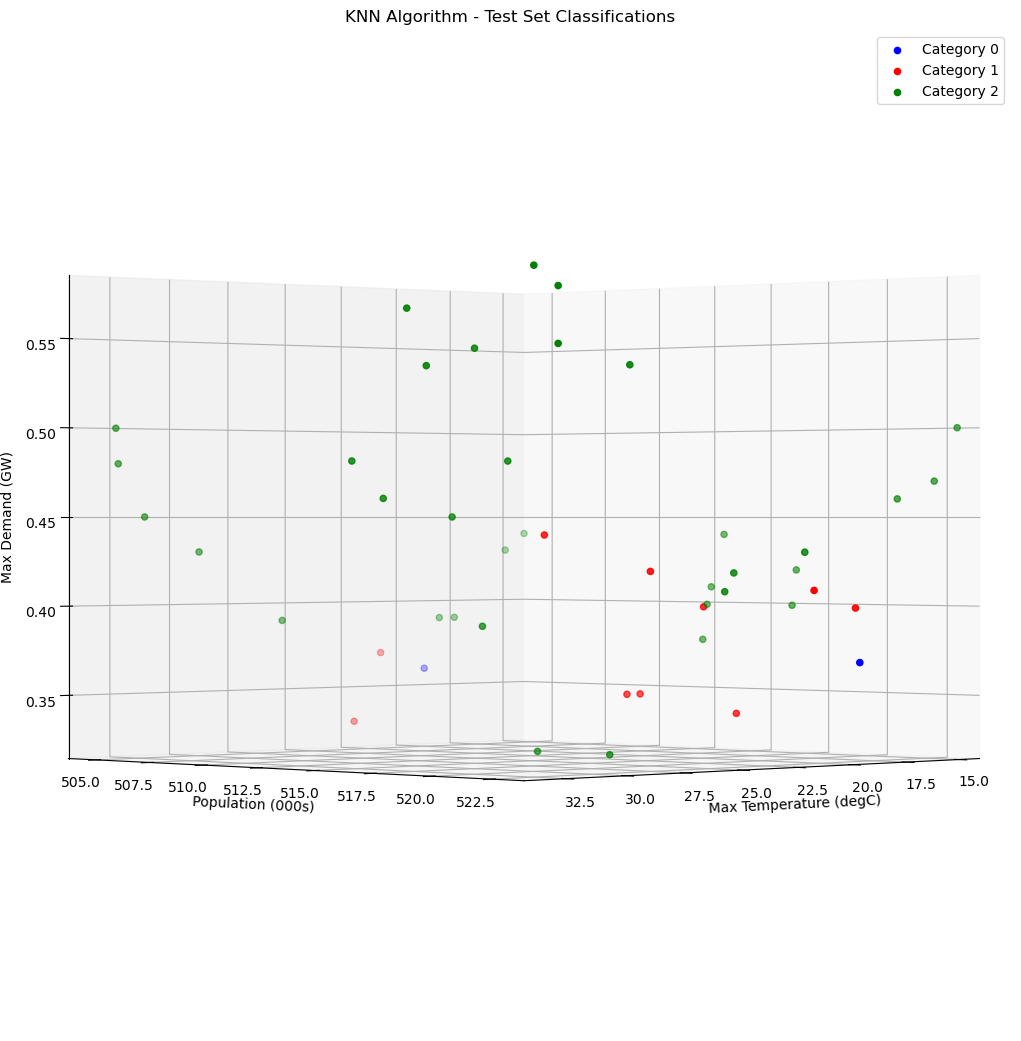

In [21]:
# Visualize the test set
fig = plt.figure(figsize=(15, 13))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each category
for category, color in zip(categories, colors):
    subset = test_data[test_data['Predicted_Category'] == category]
    ax.scatter(subset['tmax'], subset['Population_k'], subset['Max_Demand_GW'], label=f'Category {category}', c=color)

ax.set_title('KNN Algorithm - Test Set Classifications')
ax.set_xlabel('Max Temperature (degC)')
ax.set_ylabel('Population (000s)')
ax.set_zlabel('Max Demand (GW)')

ax.view_init(elev=0, azim=45)

# Set axis limits and turn off autoscale
ax.set_xlim([test_data['tmax'].min(), test_data['tmax'].max()])
ax.set_ylim([test_data['Population_k'].min(), test_data['Population_k'].max()])
ax.set_zlim([test_data['Max_Demand_GW'].min(), test_data['Max_Demand_GW'].max()])
ax.autoscale(False)

# Add legend
ax.legend()

plt.show()

# Cross Validation

In [22]:
from numpy import absolute

#The k-fold CV
from sklearn.model_selection import cross_val_score

seed = 7

#Training model CV
score_train = cross_val_score(knn_model,X_train,y_train,scoring=make_scorer(f1_score, average='micro'),cv = 5)

print(score_train)

#The absolute mean score
print(absolute(np.mean(score_train)))

[0.56410256 0.71794872 0.52631579 0.31578947 0.39473684]
0.503778677462888


# Try it yourself!

In [23]:
while True:
    # Get user input
    user_input_population = input("Enter the country's population (or 'X' to exit): ")
    
    # Check if the user wants to exit
    if user_input_population == 'X':
        print("Exiting the program.")
        break

    user_input_tmax = input("Enter the maximum temperature in degrees celcius: ")

    user_df = pd.DataFrame({'tmax': [float(user_input_tmax)],'Population_k': [float(user_input_population)/1000]})
    user_df_normalized = scaler.transform(user_df)

    # Predict the category for the user input
    predicted_category = knn_model.predict(user_df_normalized)
    
    # Map the predicted category to the corresponding range
    if predicted_category == 0:
        demand_range = "<0.330GW"
    elif predicted_category == 1:
        demand_range = ">0.330GW but <0.365GW"
    elif predicted_category == 2:
        demand_range = ">0.365GW"
    else:
        demand_range = "Unknown"

    print(f"The predicted maximum demand range for the given input is: {demand_range}")
    print("\n ------------------------------------------------------------------------------")

Enter the country's population (or 'X' to exit): X
Exiting the program.
